In [1]:
%pip install gensim
%pip install scipy

import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import os 
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
import gensim.downloader as api
from scipy.sparse import hstack

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [69]:
df = pd.read_csv("2_data_combined.csv")

In [43]:
df.shape

(90271, 6)

In [44]:
list(df.columns)

['Year',
 'Title',
 'PublicationName',
 'CitedByCount',
 'AffiliationCountry',
 'AuthorKeywords']

In [70]:
country_to_continent = {
    "Sweden": "Europe", "South Africa": "Africa", "Armenia": "Asia", "Netherlands": "Europe",
    "Maldives": "Asia", "Macao": "Asia", "Slovenia": "Europe", "Barbados": "North America",
    "Bangladesh": "Asia", "Mexico": "North America", "Taiwan": "Asia", "Georgia": "Asia",
    "Bhutan": "Asia", "South Sudan": "Africa", "Congo": "Africa", "Algeria": "Africa",
    "Belize": "North America", "Zimbabwe": "Africa", "Iran": "Asia", "Hungary": "Europe",
    "Latvia": "Europe", "Belgium": "Europe", "Denmark": "Europe", "Italy": "Europe",
    "Albania": "Europe", "Iceland": "Europe", "Democratic Republic Congo": "Africa",
    "Botswana": "Africa", "Monaco": "Europe", "Mauritius": "Africa", "Guatemala": "North America",
    "Madagascar": "Africa", "Somalia": "Africa", "Togo": "Africa", "Reunion": "Africa",
    "Bulgaria": "Europe", "El Salvador": "North America", "Sri Lanka": "Asia",
    "South Korea": "Asia", "Sudan": "Africa", "Kyrgyzstan": "Asia", "Brunei Darussalam": "Asia",
    "North Macedonia": "Europe", "Bahamas": "North America", "Qatar": "Asia", "Timor-Leste": "Asia",
    "United States": "North America", "Bahrain": "Asia", "Mali": "Africa", "Angola": "Africa",
    "Namibia": "Africa", "India": "Asia", "Venezuela": "South America", "Russian Federation": "Europe",
    "Viet Nam": "Asia", "Canada": "North America", "Cuba": "North America", "Ireland": "Europe",
    "Panama": "North America", "Oman": "Asia", "Senegal": "Africa", "Montenegro": "Europe",
    "Guinea-Bissau": "Africa", "Seychelles": "Africa", "Yemen": "Asia", "Peru": "South America",
    "Pakistan": "Asia", "Chad": "Africa", "Finland": "Europe", "Paraguay": "South America",
    "Yugoslavia": "Europe", "Azerbaijan": "Asia", "Tunisia": "Africa", "Kazakhstan": "Asia",
    "Moldova": "Europe", "Austria": "Europe", "Malaysia": "Asia", "Rwanda": "Africa",
    "Hong Kong": "Asia", "Cameroon": "Africa", "Papua New Guinea": "Oceania",
    "Czech Republic": "Europe", "Cambodia": "Asia", "Gabon": "Africa", "Niger": "Africa",
    "Portugal": "Europe", "Switzerland": "Europe", "New Zealand": "Oceania", "Singapore": "Asia",
    "Trinidad and Tobago": "North America", "Syrian Arab Republic": "Asia", "Jordan": "Asia",
    "France": "Europe", "Cote d'Ivoire": "Africa", "Eritrea": "Africa", "Argentina": "South America",
    "United Arab Emirates": "Asia", "Sierra Leone": "Africa", "Uruguay": "South America",
    "China": "Asia", "Burundi": "Africa", "Cape Verde": "Africa", "Myanmar": "Asia",
    "Egypt": "Africa", "Unknown": "Unknown", "Nicaragua": "North America", "Thailand": "Asia",
    "Liberia": "Africa", "Central African Republic": "Africa", "Puerto Rico": "North America",
    "Ecuador": "South America", "Spain": "Europe", "Brazil": "South America", "Gambia": "Africa",
    "Nepal": "Asia", "Kuwait": "Asia", "Afghanistan": "Asia", "Swaziland": "Africa",
    "Romania": "Europe", "French Guiana": "South America", "Germany": "Europe",
    "Bolivia": "South America", "Australia": "Oceania", "Greece": "Europe", "Uzbekistan": "Asia",
    "Israel": "Asia", "Chile": "South America", "Uganda": "Africa", "Haiti": "North America",
    "Morocco": "Africa", "Poland": "Europe", "Philippines": "Asia", "Mozambique": "Africa",
    "Guyana": "South America", "Zambia": "Africa", "Serbia": "Europe", "Jamaica": "North America",
    "Belarus": "Europe", "Cyprus": "Europe", "United Kingdom": "Europe", "Guinea": "Africa",
    "Honduras": "North America", "Laos": "Asia", "Indonesia": "Asia", "Fiji": "Oceania",
    "Costa Rica": "North America", "Mauritania": "Africa", "Aruba": "North America",
    "Colombia": "South America", "Burkina Faso": "Africa", "Slovakia": "Europe",
    "Dominican Republic": "North America", "Tanzania": "Africa", "Norway": "Europe",
    "Mongolia": "Asia", "Ukraine": "Europe", "Ghana": "Africa", "Iraq": "Asia",
    "Saudi Arabia": "Asia", "Benin": "Africa", "Luxembourg": "Europe",
    "Bosnia and Herzegovina": "Europe", "Lithuania": "Europe", "Ethiopia": "Africa",
    "Libya": "Africa", "Palestine": "Asia", "Lebanon": "Asia", "Croatia": "Europe",
    "Kenya": "Africa", "Malta": "Europe", "Malawi": "Africa", "Estonia": "Europe",
    "Turkey": "Asia", "Japan": "Asia", "Nigeria": "Africa", "Federated States of Micronesia": "Oceania"
}
# ฟังก์ชันเพื่อแปลงประเทศเป็นทวีป
def map_country_to_continent(countries):
    continents = [country_to_continent.get(country, 'Unknown') for country in countries.split(',')]
    return continents

# เพิ่มคอลัมน์ทวีป
df['continent'] = df['AffiliationCountry'].apply(map_country_to_continent)

# คำนวณความถี่ของแต่ละทวีปและแปลงเป็นคอลัมน์ใหม่
def calculate_continent_counts(continents):
    return {continent: continents.count(continent) for continent in set(continents)}

# สร้าง DataFrame จากผลลัพธ์ความถี่
continent_counts = df['continent'].apply(calculate_continent_counts)
continent_df = pd.DataFrame(continent_counts.tolist()).fillna(0).astype(int)

# รวม DataFrame เดิมกับ DataFrame ใหม่
result_df = pd.concat([df, continent_df], axis=1)
result_df.drop(columns='continent', inplace=True)
result_df.drop(columns='AffiliationCountry', inplace=True)

In [55]:
result_df.head(5)
result_df.shape

(90271, 12)

In [33]:
result_df.head(7500)
result_df

,Year,Title,PublicationName,CitedByCount,AuthorKeywords,Asia,Oceania,Europe,North America,Africa,South America,Unknown
0,2021,Does proactive logistics management enhance bu...,Polish Journal of Management Studies,0,"Business management,Firm size,Logistics awaren...",5,0,0,0,0,0,0
1,2021,"Will There Ever Be Cure for Chronic, Life-Chan...",Frontiers in Medicine,3,"biofilm infections,chronic infection,chronic u...",8,1,2,0,0,0,0
2,2021,Bacterial diversity and potential risk factors...,PeerJ,6,"Escherichia coli,Risk factors,Salmonella enter...",1,0,0,1,0,0,0
3,2021,Global Perspectives on Immunization Against SA...,Frontiers in Immunology,9,"COVID-19,maternal immunization,maternal vaccin...",1,6,8,3,2,2,0
4,2021,Deep Learning Enables Prostate MRI Segmentatio...,Frontiers in Oncology,4,"deep attentive neural network,large cohort eva...",2,0,1,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
90266,1981,"Synthesis of O,O-dialkyl-S-[benzoyl-(benzylide...",Proceedings of the Indian Academy of Sciences ...,0,"anti-acetylcholinesterase activity, antihookwo...",1,0,0,0,0,0,0
90267,2024,O-GlcNAc transferase congenital disorder of gl...,Journal of Biological Chemistry,2,"histone modification, intellectual disability,...",0,0,1,0,0,0,3
90268,2009,Selective hydrogenation of o-chloronitrobenzen...,Journal of Molecular Catalysis A: Chemical,52,"Laser vaporization deposition, Liquid phase hy...",1,0,0,0,0,0,0
90269,2024,Efficient and safe extraction of an antioxidan...,Food Science and Technology Research,0,"3, 4'-trihydroxy-6, 5, 7-methylenedioxyflavone...",1,0,0,0,0,0,0


In [56]:
print(result_df.columns)

Index(['Year', 'Title', 'PublicationName', 'CitedByCount', 'AuthorKeywords',
       'Asia', 'Oceania', 'Europe', 'North America', 'Africa', 'South America',
       'Unknown'],
      dtype='object')


In [71]:
result_df = result_df.sample(n=5000, random_state=42)
result_df.to_csv('sampled_result_df.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Assuming result_df is already loaded

# Filter out rows with empty 'AuthorKeywords'
result_df = result_df[result_df['AuthorKeywords'].str.strip() != ""]

# Remove outliers from 'CitedByCount' column
Q1 = result_df['CitedByCount'].quantile(0.25)
Q3 = result_df['CitedByCount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = result_df[(result_df['CitedByCount'] >= lower_bound) & (result_df['CitedByCount'] <= upper_bound)]

# Combine text columns into one
filtered_df['CombinedText'] = filtered_df['AuthorKeywords'] + ' ' + filtered_df['Title'] + ' ' + filtered_df['PublicationName']

# Vectorize combined text
vectorizer = TfidfVectorizer(max_df=0.85, min_df=1, ngram_range=(1, 3))
X_text = vectorizer.fit_transform(filtered_df['CombinedText'])

# Convert sparse matrix to DataFrame
X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the TF-IDF features with the original DataFrame
filtered_df = pd.concat([filtered_df.reset_index(drop=True), X_text_df.reset_index(drop=True)], axis=1)

# Assuming the labels are in a column named 'CitedByCount'
labels = filtered_df['CitedByCount']

# Drop the original text columns and the label column from the features
X = filtered_df.drop(columns=['AuthorKeywords', 'Title', 'PublicationName', 'CitedByCount', 'CombinedText'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train a model using the training set
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model using the testing set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


KeyboardInterrupt: 

AutoGluon


<Axes: ylabel='CitedByCount'>

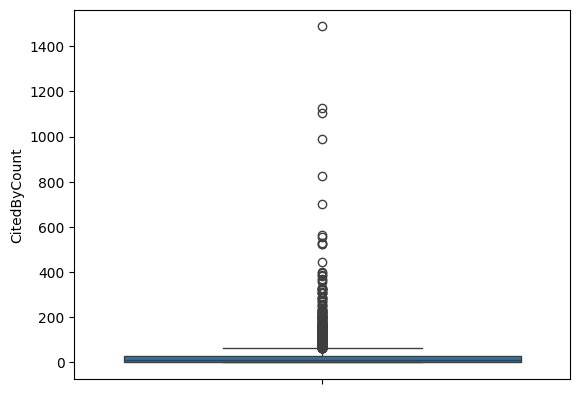

In [66]:
import seaborn as sns
sns.boxplot(result_df['CitedByCount'])

In [68]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

# Assuming result_df is already loaded

# Filter out rows with empty 'AuthorKeywords'
result_df = result_df[result_df['AuthorKeywords'].str.strip() != ""]

# Remove outliers from 'CitedByCount' column
Q1 = result_df['CitedByCount'].quantile(0.25)
Q3 = result_df['CitedByCount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = result_df[(result_df['CitedByCount'] >= lower_bound) & (result_df['CitedByCount'] <= upper_bound)]

# Select features and target
target = 'CitedByCount'  # Column to predict

# Drop rows with missing target values
filtered_df = filtered_df.dropna(subset=[target])

# Split the data into training and testing sets
train_data, test_data = train_test_split(filtered_df, test_size=0.2, random_state=42)

# Train AutoGluon model (AutoGluon will handle text preprocessing automatically)
predictor = TabularPredictor(label=target, problem_type='regression', eval_metric='mean_squared_error').fit(train_data)


# Select the best model from the leaderboard
best_model = 'WeightedEnsemble_L2'

# Predict on the test set
predictions = predictor.predict(test_data, model=best_model)

# Calculate Mean Squared Error on the test set
true_values = test_data[target]  # True values of the target
mse = mean_squared_error(true_values, predictions)

print(f"Mean Squared Error (MSE) for {best_model}: {mse:.4f}")

No path specified. Models will be saved in: "AutogluonModels\ag-20241205_185356"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22635
CPU Count:          24
Memory Avail:       12.67 GB / 31.92 GB (39.7%)
Disk Space Avail:   128.94 GB / 464.27 GB (27.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'        

[1000]	valid_set's l2: 166.828


	-166.803	 = Validation score   (-mean_squared_error)
	5.94s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'CatBoost': 0.636, 'LightGBM': 0.227, 'ExtraTreesMSE': 0.136}
	-153.5017	 = Validation score   (-mean_squared_error)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 40.67s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 8565.5 rows/s (501 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("c:\Users\ananz\ArticlePopularityPrediction\AutogluonModels\ag-20241205_185356")


Mean Squared Error (MSE) for WeightedEnsemble_L2: 151.2780


In [72]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

# Assuming result_df is already loaded

# Filter out rows with empty 'AuthorKeywords'
result_df = result_df[result_df['AuthorKeywords'].str.strip() != ""]

# Remove outliers from 'CitedByCount' column
Q1 = result_df['CitedByCount'].quantile(0.25)
Q3 = result_df['CitedByCount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = result_df[(result_df['CitedByCount'] >= lower_bound) & (result_df['CitedByCount'] <= upper_bound)]

# Select features and target
target = 'CitedByCount'  # Column to predict

# Drop rows with missing target values
filtered_df = filtered_df.dropna(subset=[target])

# Split the data into training and testing sets
train_data, test_data = train_test_split(filtered_df, test_size=0.2, random_state=42)

# Train AutoGluon model (AutoGluon will handle text preprocessing automatically)
predictor = TabularPredictor(label=target, problem_type='regression', eval_metric='mean_squared_error').fit(train_data)

# Select the best model from the leaderboard
best_model = 'WeightedEnsemble_L2'

# Predict on the training set
train_predictions = predictor.predict(train_data, model=best_model)

# Predict on the test set
test_predictions = predictor.predict(test_data, model=best_model)

# Calculate Mean Squared Error on the training set
train_true_values = train_data[target]  # True values of the target
train_mse = mean_squared_error(train_true_values, train_predictions)

# Calculate Mean Squared Error on the test set
test_true_values = test_data[target]  # True values of the target
test_mse = mean_squared_error(test_true_values, test_predictions)

print(f"Mean Squared Error (MSE) for {best_model} on training set: {train_mse:.4f}")
print(f"Mean Squared Error (MSE) for {best_model} on test set: {test_mse:.4f}")

# Check for overfitting
if train_mse < test_mse:
    print("The model may be overfitting.")
else:
    print("The model does not appear to be overfitting.")

No path specified. Models will be saved in: "AutogluonModels\ag-20241205_185743"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22635
CPU Count:          24
Memory Avail:       12.98 GB / 31.92 GB (40.7%)
Disk Space Avail:   128.79 GB / 464.27 GB (27.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'        

Mean Squared Error (MSE) for WeightedEnsemble_L2 on training set: 43.3379
Mean Squared Error (MSE) for WeightedEnsemble_L2 on test set: 150.0857
The model may be overfitting.


In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

# Filter out rows with empty 'AuthorKeywords'
result_df = result_df[result_df['AuthorKeywords'].str.strip() != ""]

# Select features and target
target = 'CitedByCount'  # คอลัมน์ที่ต้องการพยากรณ์

# Drop rows with missing target values
result_df = result_df.dropna(subset=[target])

# Split the data into training and testing sets
train_data, test_data = train_test_split(result_df, test_size=0.2, random_state=42)

# Train AutoGluon model (AutoGluon will handle text preprocessing automatically)
predictor = TabularPredictor(label=target, eval_metric='mean_squared_error').fit(train_data)

# Evaluate the model using the testing set
leaderboard = predictor.leaderboard(test_data)
print(leaderboard)


No path specified. Models will be saved in: "AutogluonModels\ag-20241205_184441"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22635
CPU Count:          24
Memory Avail:       13.09 GB / 31.92 GB (41.0%)
Disk Space Avail:   129.25 GB / 464.27 GB (27.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'        

                  model   score_test    score_val         eval_metric  \
0       RandomForestMSE -2282.111097 -1458.491643  mean_squared_error   
1              CatBoost -2337.235640 -1204.855610  mean_squared_error   
2         ExtraTreesMSE -2365.688199 -1366.155810  mean_squared_error   
3   WeightedEnsemble_L2 -2427.157004 -1107.000676  mean_squared_error   
4            LightGBMXT -2497.005805 -1189.790520  mean_squared_error   
5              LightGBM -2511.041513 -1236.285857  mean_squared_error   
6       NeuralNetFastAI -2626.020449 -1452.339982  mean_squared_error   
7        NeuralNetTorch -2706.903615 -1235.755643  mean_squared_error   
8         LightGBMLarge -2733.159288 -1339.457513  mean_squared_error   
9               XGBoost -2747.459568 -1485.636586  mean_squared_error   
10       KNeighborsDist -2886.225383 -1735.335600  mean_squared_error   
11       KNeighborsUnif -2892.351086 -1748.964640  mean_squared_error   

    pred_time_test  pred_time_val   fit_time  pred

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model using the testing set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits


KeyboardInterrupt: 

In [8]:
word2vec = api.load('glove-wiki-gigaword-50')  # ใช้ GloVe vector 50 มิติ

# กรองข้อมูลที่ไม่ว่างเปล่า
result_df = result_df[result_df['AuthorKeywords'].str.strip() != ""]

# แยกคำสำคัญในแต่ละแถว
result_df['keywords_list'] = result_df['AuthorKeywords'].str.split(',')

# สร้าง Word Embeddings สำหรับแต่ละแถว
def get_average_embedding(keywords):
    if not isinstance(keywords, list):
        return np.zeros(word2vec.vector_size)
    
    vectors = [word2vec[word] for word in keywords if word in word2vec]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec.vector_size)

result_df['embedding'] = result_df['keywords_list'].apply(get_average_embedding)

# แปลง embeddings เป็น array
embeddings = np.vstack(result_df['embedding'].values)

# ใช้ K-Means Clustering
n_clusters = 5  # ปรับจำนวนคลัสเตอร์ตามต้องการ
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
result_df['cluster'] = kmeans.fit_predict(embeddings)

# คำนวณ Silhouette Score
silhouette_avg = silhouette_score(embeddings, result_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.9297005296760786


In [9]:
# Fill NaN values in 'keywords_list' with an empty list
result_df['keywords_list'] = result_df['keywords_list'].apply(lambda x: x if isinstance(x, list) else [])

for cluster_id in range(n_clusters):
    print(f"Cluster {cluster_id}:")
    cluster_keywords = result_df[result_df['cluster'] == cluster_id]['keywords_list']
    flat_keywords = [keyword for sublist in cluster_keywords for keyword in sublist]
    top_keywords = pd.Series(flat_keywords).value_counts().head(10)
    print(top_keywords)

Cluster 0:
 Vitamin D                       4696
 N                               1309
 Vitamin D deficiency            1043
25-hydroxyvitamin D               983
 vitamin D                        969
 g-C<sub>3</sub>N<sub>4</sub>     845
 Photocatalysis                   810
 G-quadruplex                     701
 Hepatitis B virus                662
B cells                           633
Name: count, dtype: int64
Cluster 1:
 vitamin D               171
children                  83
cancer                    61
 Vitamin D                47
inflammation              40
adolescents               37
Thailand                  37
 vitamin D deficiency     36
depression                34
aging                     34
Name: count, dtype: int64
Cluster 2:
 vitamin D      108
apoptosis        80
autoimmunity     68
 B cells         66
biomarker        42
antibody         41
 N               39
antibodies       38
adsorption       32
antioxidant      31
Name: count, dtype: int64
Cluster 3:
1       

In [38]:
cluster_labels = {
    0: 'Sustainability and Diversity',
    1: 'Medical and Technological Advances',
    2: 'Cell Biology and Biochemistry',
    3: 'Materials Science and Taxonomy',
    4: 'Public Health and Epidemiology',
}

result_df['cluster_label'] = result_df['cluster'].map(cluster_labels)
value_counts = result_df['cluster_label'].value_counts()
result_df.rename(columns={'cluster_label': 'keyword_category'}, inplace=True)
print(value_counts)


cluster_label
Medical and Technological Advances    6902
Cell Biology and Biochemistry          920
Sustainability and Diversity           550
Public Health and Epidemiology         444
Materials Science and Taxonomy         165
Name: count, dtype: int64


In [39]:
result_df.head(5)

,Year,Title,PublicationName,CitedByCount,AuthorKeywords,Asia,Europe,Oceania,North America,Africa,South America,Unknown,keywords_list,embedding,cluster,keyword_category,keyword_category
0,2021,Does proactive logistics management enhance bu...,Polish Journal of Management Studies,0,"Business management,Firm size,Logistics awaren...",5,0,0,0,0,0,0,"[Business management, Firm size, Logistics awa...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,Medical and Technological Advances,Medical and Technological Advances
1,2021,"Will There Ever Be Cure for Chronic, Life-Chan...",Frontiers in Medicine,3,"biofilm infections,chronic infection,chronic u...",8,2,1,0,0,0,0,"[biofilm infections, chronic infection, chroni...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,Medical and Technological Advances,Medical and Technological Advances
2,2021,Bacterial diversity and potential risk factors...,PeerJ,6,"Escherichia coli,Risk factors,Salmonella enter...",1,0,0,1,0,0,0,"[Escherichia coli, Risk factors, Salmonella en...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,Medical and Technological Advances,Medical and Technological Advances
3,2021,Global Perspectives on Immunization Against SA...,Frontiers in Immunology,9,"COVID-19,maternal immunization,maternal vaccin...",1,8,6,3,2,2,0,"[COVID-19, maternal immunization, maternal vac...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,Medical and Technological Advances,Medical and Technological Advances
4,2021,Deep Learning Enables Prostate MRI Segmentatio...,Frontiers in Oncology,4,"deep attentive neural network,large cohort eva...",2,1,0,4,0,0,0,"[deep attentive neural network, large cohort e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,Medical and Technological Advances,Medical and Technological Advances


In [40]:
result_df.drop(columns="AuthorKeywords", inplace=True)
result_df.drop(columns="embedding", inplace=True)

result_df

,Year,Title,PublicationName,CitedByCount,Asia,Europe,Oceania,North America,Africa,South America,Unknown,keywords_list,cluster,keyword_category,keyword_category
0,2021,Does proactive logistics management enhance bu...,Polish Journal of Management Studies,0,5,0,0,0,0,0,0,"[Business management, Firm size, Logistics awa...",1,Medical and Technological Advances,Medical and Technological Advances
1,2021,"Will There Ever Be Cure for Chronic, Life-Chan...",Frontiers in Medicine,3,8,2,1,0,0,0,0,"[biofilm infections, chronic infection, chroni...",1,Medical and Technological Advances,Medical and Technological Advances
2,2021,Bacterial diversity and potential risk factors...,PeerJ,6,1,0,0,1,0,0,0,"[Escherichia coli, Risk factors, Salmonella en...",1,Medical and Technological Advances,Medical and Technological Advances
3,2021,Global Perspectives on Immunization Against SA...,Frontiers in Immunology,9,1,8,6,3,2,2,0,"[COVID-19, maternal immunization, maternal vac...",1,Medical and Technological Advances,Medical and Technological Advances
4,2021,Deep Learning Enables Prostate MRI Segmentatio...,Frontiers in Oncology,4,2,1,0,4,0,0,0,"[deep attentive neural network, large cohort e...",1,Medical and Technological Advances,Medical and Technological Advances
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8976,2022,A Systematic Review on Rhodomyrtus Tomentosa (...,International Journal of Pharmaceutical Scienc...,6,1,0,0,0,0,0,0,"[Anti-inflammatory, Antibiotic, Antimicrobia...",1,Medical and Technological Advances,Medical and Technological Advances
8977,2020,Modified sialic acids on mucus and erythrocyte...,Journal of Virology,34,0,0,0,1,0,0,0,"[Influenza, Mucus, Sialic acids]",1,Medical and Technological Advances,Medical and Technological Advances
8978,2021,A review on microbial products and their persp...,Biomolecules,37,1,0,0,0,0,0,2,"[Bacteriocins, Chlorellin, Filamentous fungi...",1,Medical and Technological Advances,Medical and Technological Advances
8979,2010,Negative regulation of gamma-aminobutyric acid...,Neural Regeneration Research,1,1,0,0,0,0,0,0,"[Calcium ion, Facial nerve injury, Facial nu...",1,Medical and Technological Advances,Medical and Technological Advances


In [41]:
list(result_df.columns)

['Year',
 'Title',
 'PublicationName',
 'CitedByCount',
 'Asia',
 'Europe',
 'Oceania',
 'North America',
 'Africa',
 'South America',
 'Unknown',
 'keywords_list',
 'cluster',
 'keyword_category',
 'keyword_category']

In [42]:
result_df = result_df.loc[:, ~result_df.columns.duplicated()]
list(result_df.columns)

['Year',
 'Title',
 'PublicationName',
 'CitedByCount',
 'Asia',
 'Europe',
 'Oceania',
 'North America',
 'Africa',
 'South America',
 'Unknown',
 'keywords_list',
 'cluster',
 'keyword_category']

In [44]:
result_df.shape

(8981, 14)

In [48]:
result_df['Unknown'].value_counts()

Unknown
0    8630
1     272
2      52
3      17
4       5
5       4
6       1
Name: count, dtype: int64

In [49]:
filtered_df = result_df[result_df['Unknown'] == 0]

In [50]:
filtered_df['Unknown'].value_counts()

Unknown
0    8630
Name: count, dtype: int64

In [52]:
filtered_df.drop(columns='Unknown', inplace=True)

C:\Users\Amphi\AppData\Local\Temp\ipykernel_1316\25066785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns='Unknown', inplace=True)


In [54]:
filtered_df.shape

(8630, 13)

In [53]:
filtered_df.head(5)

,Year,Title,PublicationName,CitedByCount,Asia,Europe,Oceania,North America,Africa,South America,keywords_list,cluster,keyword_category
0,2021,Does proactive logistics management enhance bu...,Polish Journal of Management Studies,0,5,0,0,0,0,0,"[Business management, Firm size, Logistics awa...",1,Medical and Technological Advances
1,2021,"Will There Ever Be Cure for Chronic, Life-Chan...",Frontiers in Medicine,3,8,2,1,0,0,0,"[biofilm infections, chronic infection, chroni...",1,Medical and Technological Advances
2,2021,Bacterial diversity and potential risk factors...,PeerJ,6,1,0,0,1,0,0,"[Escherichia coli, Risk factors, Salmonella en...",1,Medical and Technological Advances
3,2021,Global Perspectives on Immunization Against SA...,Frontiers in Immunology,9,1,8,6,3,2,2,"[COVID-19, maternal immunization, maternal vac...",1,Medical and Technological Advances
4,2021,Deep Learning Enables Prostate MRI Segmentatio...,Frontiers in Oncology,4,2,1,0,4,0,0,"[deep attentive neural network, large cohort e...",1,Medical and Technological Advances


In [55]:
filtered_df.to_csv('real_data.csv', index=False)